In [2]:
from datetime import datetime

print()
start = datetime.now()
print(f'Start Time : {start}')


Start Time : 2023-07-25 15:46:05.863490


In [3]:
from tab_opt.optimize.mcmc import inv_kernel_vmap, inv_kernel, log_normal, log_multinorm, log_multinorm_sum
from tabascal.jax.coordinates import orbit
from tabascal.utils.jax import progress_bar_scan

from jax import random, jit, vmap, jacrev
import jax.numpy as jnp

from jax.flatten_util import ravel_pytree as flatten
from jax.lax import scan

from jax.tree_util import tree_map
import jax

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py

import dask.array as da
import xarray as xr

import os

plt.rcParams['font.size'] = 16

In [88]:
N_ant = 4

sim_dir = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/"
f_name = f"target_obs_{N_ant:02}A_450T-0440-1338_128I_001F-1.227e+09-1.227e+09_100AST_1SAT_0GRD/"

sim_path = os.path.join(sim_dir, f_name)

ds = xr.open_zarr(sim_path)

In [89]:
sampling = 1
N_time = 30

N_int_samples = ds.attrs["n_int_samples"]//sampling
N_ant = ds.attrs["n_ant"]
N_bl = ds.attrs["n_bl"]
# N_time = ds.attrs["n_time"]
times = ds.coords["time"].data[:N_time]
times_fine = ds.coords["time_fine"].data[:N_time*N_int_samples:sampling]
bl_uvw = ds.bl_uvw.data.compute()[:N_time*N_int_samples:sampling]
ants_uvw = ds.ants_uvw.data.compute()[:N_time*N_int_samples:sampling]
ants_xyz = ds.ants_xyz.data.compute()[:N_time*N_int_samples:sampling]
vis_ast = ds.vis_ast.data.compute()[:N_time*N_int_samples:sampling]
vis_rfi = ds.vis_rfi.data.compute()[:N_time*N_int_samples:sampling]
vis_obs = ds.vis_obs.data.compute()[:N_time]
noise = ds.noise_std.data.compute()[:N_time]
noise_data = ds.noise_data.data.compute()[:N_time]
int_time = ds.attrs["int_time"]
freqs = ds.coords["freq"].data
gains_ants = ds.gains_ants.data.compute()[:N_time*N_int_samples:sampling]
rfi_A_app = ds.rfi_sat_A.data.compute()[0,:N_time*N_int_samples:sampling]
rfi_orbit = ds.rfi_sat_orbit.data.compute()[0]

In [90]:
vis_obs.shape

(30, 6, 1)

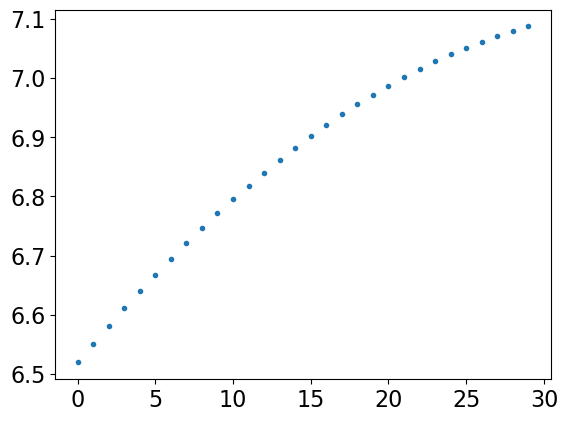

In [91]:
plt.plot(np.real(vis_ast)[::N_int_samples,0,0], '.')

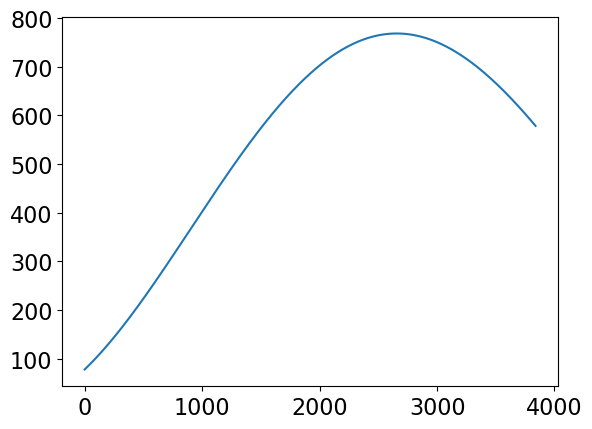

In [92]:
plt.plot(np.abs(vis_rfi)[:,0,0])

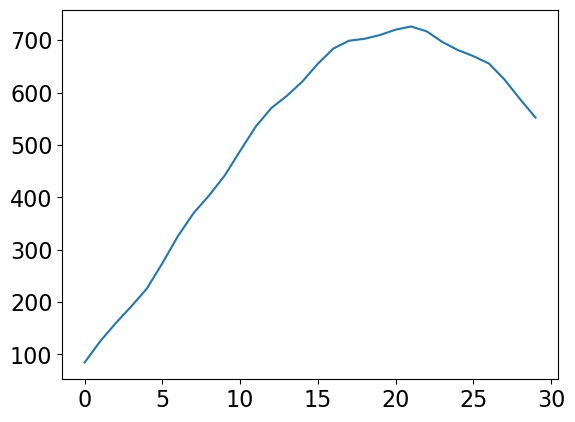

In [93]:
plt.plot(np.abs(vis_obs)[:,0,0])

In [94]:
from tabascal.jax.interferometry import ants_to_bl
a1 = ds.antenna1.data.compute()
a2 = ds.antenna2.data.compute()
gains_bl = ants_to_bl(gains_ants.reshape(N_time, -1, N_ant, 1).mean(axis=1), a1, a2)

v_ast = vis_ast.reshape(N_time,-1,N_bl,1).mean(axis=1)

v_cal = vis_obs/gains_bl

flags = jnp.where(jnp.abs(v_ast-v_cal)>3*noise, True, False)

In [152]:
rfi_gains.shape

(3840, 4, 1)

In [193]:
rng = np.random.default_rng(123)
rfi_gains = np.exp(1.j*times_fine/100.)[:,None,None] * np.exp(2.j*np.pi*rng.uniform(size=N_ant))[None,:,None]
rfi_gains = np.ones_like(rfi_gains)

v_rfi = rfi_gains[:,a1]*np.conj(rfi_gains[:,a2])*vis_rfi

In [194]:
v_obs = ( gains_ants[:,a1]*np.conj(gains_ants[:,a2]) * (vis_ast + v_rfi) ).reshape(N_time, N_int_samples, N_bl, 1).mean(axis=1) + noise_data

In [195]:
print(f'Mean RFI Amp. : {jnp.mean(jnp.abs(v_rfi)):.0f} Jy\nFlag Rate :     {100*flags.mean():.2f} %')

Mean RFI Amp. : 550 Jy
Flag Rate :     100.00 %


In [196]:
print()
print(f'Number of Antennas: {N_ant}')
print()
print(f'Number of Time Steps: {N_time}')


Number of Antennas: 4

Number of Time Steps: 30


In [197]:
@jit
def kernel(x, x_, var, l, noise=1e-3):
    '''
    x: array (n_points, n_dim)
    '''
    x = x[:,None] if x.ndim==1 else x
    x_ = x_[:,None] if x_.ndim==1 else x_
    chi = jnp.linalg.norm(x[None,:,:]-x_[:,None,:], axis=-1) / l
    cov = jnp.abs(var)*jnp.exp(-0.5*chi**2)
    if chi.shape[0]==chi.shape[1]:
        cov += noise*jnp.eye(x.shape[0])
    return cov

@jit
def resampling_kernel(x, x_, var, l, noise=1e-3):
    K_inv = jnp.linalg.inv(kernel(x, x, var, l, noise))
    K_s = kernel(x, x_, var, l)
    return K_s@K_inv

In [198]:
@jit
def gp_resample(y, x, x_, var, l, noise=1e-3):
    K_inv = jnp.linalg.inv(kernel(x, x, var, l, noise))
    K_s = kernel(x, x_, var, l)
    return K_s@K_inv@y

@jit
def resampled_cov(x, x_, var, l, noise_cov):
    K = kernel(x, x, var, l, 1e-3)
    K_inv = jnp.linalg.inv(K + noise_cov)
    K_s = kernel(x, x_, var, l)
    K_ss = kernel(x_, x_, var, l)
    return K_ss - K_s@K_inv@K_s.T

In [199]:
def l_from_uv(uv, l0=7e2, a=6e-4):
    return l0*jnp.exp(-a*uv)

def get_times(gp_l, times):
    
    int_time = times[1] - times[0]
    t_i = times[0] - int_time/2
    t_f = times[-1] + int_time/2
    n_vis_times = jnp.ceil(2. * ((t_f - t_i)/gp_l) + 1).astype(int)
    vis_times = jnp.linspace(t_i, t_f, n_vis_times)
    
    return vis_times

def fringe_phasor(w, freq):
    
    from tabascal.jax.interferometry import c
    phasor = jnp.exp(-2.j*jnp.pi*freq/c*w)
    
    return phasor

def derotated_vis_phase(vis, w, freq):
    
    derotated_vis = vis*fringe_phasor(w, freq)
    phase = jnp.unwrap(jnp.angle(derotated_vis), discont=0.0)
    
    return phase

def derotated_vis(vis, w, freq):
    
    return vis*fringe_phasor(w, freq)

In [200]:
# @jit
# def rfi_closures(q, params, ants):

#     # rfi_amp = flatten(q['rfi_amp'])[0].reshape(N_ant,N_rfi_time)[ants]
#     # rfi_amp = (params['resample_rfi']@rfi_amp.T).T
    
#     rfi_real = flatten(q['rfi_real'])[0].reshape(N_ant,N_rfi_time)[ants]
#     rfi_imag = flatten(q['rfi_imag'])[0].reshape(N_ant,N_rfi_time)[ants]
#     rfi_amp = (params['resample_rfi']@(rfi_real + 1.j*rfi_imag).T).T

#     rfi_xyz = orbit(params['times_fine'], *q['rfi_orbit'])
#     distances = jnp.linalg.norm(params['ants_xyz'][:,ants]-rfi_xyz[:,None,:], axis=2)
#     c_distances = (distances-params['phase_corrections'][:,ants])[...,None]

#     return rfi_amp, c_distances

# @jit
# def rfi_vis(app_amplitude, c_distances, freqs):
#     '''
#     Calculate visibilities from distances to rfi sources.

#     Parameters:
#     -----------
#     app_amplitude: jnp.array (n_time, 2, n_freq, n_src)
#         Apparent amplitude at the antennas.
#     c_distances: jnp.array (n_time, 2, n_src)
#         The phase corrected distances between the rfi sources and the antennas.
#     freqs: jnp.array (n_freq,)
#         Frequencies.

#     Returns:
#     --------
#     vis: jnp.array (n_time, 1, n_freq)
#         The visibilities.
#     '''
#     n_time, n_ant, n_freq, n_src = app_amplitude.shape
#     c = 2.99792458e8

#     # Create array of shape (n_time, n_bl, n_freq, n_src) and then sum over n_src

#     minus_two_pi_over_lamda = (-2.0*jnp.pi*freqs/c).reshape(1,1,n_freq,1)

#     c_distances = c_distances.reshape(n_time,n_ant,1,n_src)

#     phase = minus_two_pi_over_lamda*(c_distances[:,0]-c_distances[:,1])
#     intensities_app = app_amplitude[:,0]*jnp.conj(app_amplitude[:,1])

#     vis = jnp.sum(intensities_app*jnp.exp(1.j*phase), axis=-1)

#     return vis

@jit
def baseline_gains(q, params, ants):
    
    G_amp = flatten(q['g_amp'])[0].reshape(N_ant, N_g_time)[ants]
    G_phase = flatten(q['g_phase'])[0].reshape(N_ant-1, N_g_time)
    G_phase = jnp.concatenate([G_phase, jnp.zeros((1, N_g_time))], axis=0)[ants]
    
    G_amp = (params['resample_g_amp']@G_amp.T).T
    G_phase = (params['resample_g_phase']@G_phase.T).T
    

    G = G_amp*jnp.exp(1.j*G_phase)
    
    return G[0]*jnp.conjugate(G[1])

@jit
def pad_vis(vis):
    
    return jnp.pad(vis, (0, N_vis_time-vis.shape[0]))

# @jit
# def rfi_vis_model(q, params, ant1, ant2):
    
#     q = scale_parameters(q, inv_scalings)
    
#     ants = jnp.array([ant1, ant2])
    
#     rfi_amp, c_distances = rfi_closures(q, params, ants)
#     V_rfi = rfi_vis(rfi_amp.T[:,:,None,None], c_distances, params['freqs'])[...,0]
    
#     return V_rfi

@jit
def rfi_vis_model(q, params, ants, bl):
    
    a1, a2 = ants
    rfi_amp = flatten(q['rfi_amp'])[0].reshape(N_ant,N_rfi_time)[ants]
    rfi_I = rfi_amp[0]*rfi_amp[1]
    V_rfi = params['rfi_kernel'][:,:,bl]@rfi_I
    
    return V_rfi

@jit
def ast_vis_model(q, params, bl):

    V_real = flatten(tree_map(pad_vis, q['v_real']))[0].reshape(N_bl, N_vis_time)[bl]
    V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)[bl]
    V_ast = V_real + 1.j*V_imag
    
    V_ast = params['resample_vis'][bl]@V_ast
    
    return V_ast

@jit
def model(q, params, ant1, ant2, bl):
    
    q = scale_parameters(q, inv_scalings)

    ants = jnp.array([ant1, ant2])
    
    V_real = flatten(tree_map(pad_vis, q['v_real']))[0].reshape(N_bl, N_vis_time)[bl]
    V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)[bl]
    V_ast = V_real + 1.j*V_imag
    
    V_ast = params['resample_vis'][bl]@V_ast

#     Calculate the visibility contribution from the RFI
    # rfi_amp, c_distances = rfi_closures(q, params, ants)
    # V_rfi = rfi_vis(rfi_amp.T[:,:,None,None], c_distances, params['freqs'])[...,0]
    # V_rfi = V_rfi.reshape(N_time, N_int_samples).mean(axis=1)
    
    V_rfi = rfi_vis_model(q, params, ants, bl)

    G_bl = baseline_gains(q, params, ants)

    model_vis = (G_bl*(V_ast+V_rfi))

    return jnp.concatenate([model_vis.real.flatten(), model_vis.imag.flatten()])

# @jit
def scale_parameters(q, scalings):
    q['g_amp'] = tree_map(lambda x: scalings['g_amp']*x, q['g_amp'])
    q['g_phase'] = tree_map(lambda x: scalings['g_phase']*x, q['g_phase'])
    # q['rfi_orbit'] = scalings['rfi_orbit']@q['rfi_orbit']
    return q

In [201]:
scalings = {'g_amp': jnp.array([100.]),
            'g_phase': jnp.rad2deg(1.),
            'rfi_orbit': jnp.diag(jnp.array([1e-2, 3600e0, 3600e1, 3600e1]))}

# scalings = {'g_amp': jnp.array([1.]),
#             'g_phase': jnp.array([1.]),
#             'rfi_orbit': jnp.eye(4)}

inv_scalings = tree_map(lambda x: jnp.linalg.inv(x) if x.ndim==2 else 1./x, scalings)

# Calculate approximate True values

def l_from_uv(uv, l0=7e2, a=6e-4):
    return l0*jnp.exp(-a*uv)

a1, a2 = jnp.triu_indices(N_ant, 1)
mag_uvw = jnp.linalg.norm(ants_uvw[0, a1] - ants_uvw[0, a2], axis=-1)
vis_var = (jnp.abs(vis_ast).max(axis=(0,2)) + noise)**2
vis_l = l_from_uv(mag_uvw, l0=5e2)

g_amp_var = (0.01*scalings['g_amp'])**2
g_phase_var = (jnp.deg2rad(1.)*scalings['g_phase'])**2
g_l = 10e3

rfi_var, rfi_l = 1e6, 15.

T_time = times[-1]-times[0]+int_time
n_vis_times = jnp.ceil(2.*T_time/vis_l).astype(int)
get_times = partial(jnp.linspace, *(times[0]-int_time/2, times[-1]+int_time/2))
vis_times = tuple(map(get_times, n_vis_times))
N_vis_time = int(n_vis_times.max())

vis_idxs = [jnp.floor(jnp.linspace(0, len(times_fine)-1, n_vis_times[i])).astype(int) for i in range(N_bl)]

Nt_fine = len(times_fine)
#####
Nt_g = N_int_samples*45
# Nt_g = N_int_samples * 150
g_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_g)) + \
                [Nt_fine-1,])
times_g = times_fine[g_idx]
N_g_time = len(times_g)
G = gains_ants[g_idx,:,0].T
#####
Nt_rfi = N_int_samples # 2
rfi_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_rfi)) + \
                [Nt_fine-1,])
times_rfi = times_fine[rfi_idx]
N_rfi_time = len(times_rfi)
rfi_A = rfi_A_app[rfi_idx,:,0].T

rfi_signal = rfi_A_app*rfi_gains
rfi_real = rfi_signal[rfi_idx,:,0].T.real
rfi_imag = rfi_signal[rfi_idx,:,0].T.imag

######
true_values = {'g_amp': {i: x for i, x in enumerate(jnp.abs(G))},
               'g_phase': {i: x for i, x in enumerate(jnp.angle(G[:-1]))},
               'rfi_amp': {i: x for i, x in enumerate(rfi_A)},
               # 'rfi_real': {i: x for i, x in enumerate(rfi_real)},
               # 'rfi_imag': {i: x for i, x in enumerate(rfi_imag)},
               # 'rfi_orbit': rfi_orbit,
               'v_real': {i: vis_ast.real[vis_idxs[i],i,0] for i in range(N_bl)},
               'v_imag': {i: vis_ast.imag[vis_idxs[i],i,0] for i in range(N_bl)}
               }

true_values = scale_parameters(true_values, scalings)
flat_true_values, unflatten = flatten(true_values)

####################################################################

In [202]:
# Set Constant Parameters
params = {'freqs': freqs,
          'times_fine': times_fine,
          'noise': noise if noise>0 else 0.2,
          'ants_xyz': ants_xyz,
          'phase_corrections': ants_uvw[...,-1],
          # 'vis_obs': vis_obs[:,:,0],
          'vis_obs': v_obs[:,:,0],
          }

def sym(x):
    return (x + x.T)/2.

rfi_cov_fp = 'data/RFIorbitCov5min.npy'

cov_RFI_orbit = scalings['rfi_orbit']@np.load(rfi_cov_fp)@scalings['rfi_orbit']
inv_cov_RFI_orbit = sym(jnp.linalg.inv(cov_RFI_orbit))
rfi_orbit = rfi_orbit

prior_params = {'mu_RFI_orbit': scalings['rfi_orbit']@rfi_orbit,
                'inv_cov_RFI_orbit': inv_cov_RFI_orbit,
                'mu_G_amp': scalings['g_amp']*jnp.abs(G),
                'mu_G_phase': scalings['g_phase']*jnp.angle(G)[:-1],
                'rfi_amp_std': 100.0,
                'mu_vis': {i: jnp.zeros(len(vis_times[i])) for i in range(N_bl)},
                'inv_cov_vis': {i: inv_kernel(vis_times[i][:,None], vis_var[i], 
                                              vis_l[i]) for i in range(N_bl)},
                'inv_cov_G_amp': inv_kernel(times_g[:,None],
                                            g_amp_var, g_l),
                'inv_cov_G_phase': inv_kernel(times_g[:,None],
                                              g_phase_var, g_l),
                'resample_vis': {i: resampling_kernel(vis_times[i], times, vis_var[i], 
                                                      vis_l[i], 1e-3) for i in range(N_bl)},
                'resample_g_amp': resampling_kernel(times_g, 
                                                    times, 
                                                    g_amp_var, g_l, 1e-8),
                'resample_g_phase': resampling_kernel(times_g, 
                                                      times, 
                                                      g_phase_var, g_l, 1e-8),
                'resample_rfi': resampling_kernel(times_rfi, 
                                                  params['times_fine'], 
                                                  rfi_var, rfi_l, 1e-6)
               }

prior_params['resample_vis'] = jnp.array([jnp.pad(x, ((0,0),(0,N_vis_time-x.shape[1]))) 
                                          for x in prior_params['resample_vis'].values()])

params.update(prior_params)

flatten(true_values['v_real'])[0].shape[0], N_vis_time*N_bl, N_time*N_bl, \
flatten(true_values['v_real'])[0].shape[0]/(N_vis_time*N_bl), \
flatten(true_values['v_real'])[0].shape[0]/(N_time*N_bl)

(10, 18, 180, 0.5555555555555556, 0.05555555555555555)

In [203]:
params['resample_vis'].shape

(6, 30, 3)

In [204]:
resample_rfi = params['resample_rfi']
rfi_amp = jnp.abs(vis_rfi)[:,:,0]
rfi_phasor = vis_rfi[:,:,0]/rfi_amp
averaging_kernel = jnp.array([i*N_int_samples*[0,] + N_int_samples*[1,] + (N_time-i-1)*N_int_samples*[0,] for i in range(N_time)])/N_int_samples

rfi_kernel = jnp.transpose(averaging_kernel @ (rfi_phasor[None,:,:]*resample_rfi.T[:,:,None]), (1,0,2))

params.update({'rfi_kernel': rfi_kernel})

In [205]:
rfi_kernel.shape

(30, 31, 6)

In [206]:
rfi_I = (rfi_A[a1]*rfi_A[a2]).T[None,:,:]
vis_rfi_test = (rfi_kernel*rfi_I).sum(axis=1)
vis_rfi_true = vis_rfi.reshape(N_time, N_int_samples, N_bl).mean(axis=1)

rel_rmse = jnp.sqrt(jnp.mean( jnp.abs(vis_rfi_test/vis_rfi_true - 1)**2 ))

print('Assuming an orbit and compressing all resampling and phase multiplication and averaging into a single matrix')
print('-----------------------------------------------------')
print(f'Relative Root Mean Squared Error : {rel_rmse: .2E}')

Assuming an orbit and compressing all resampling and phase multiplication and averaging into a single matrix
-----------------------------------------------------
Relative Root Mean Squared Error :  6.52E-05


In [207]:
print()
print(f'Max and Min Vis samples : ({int(n_vis_times.max())}, {int(n_vis_times.min())})')


Max and Min Vis samples : (3, 1)


In [208]:
inv_cov_vis = jnp.array([jnp.pad(x, ((0,N_vis_time-x.shape[0]),(0,N_vis_time-x.shape[1]))) 
                                          for x in prior_params['inv_cov_vis'].values()])

In [209]:
sigma = flatten(tree_map(lambda x: jnp.sqrt(jnp.diag(jnp.linalg.inv(x))), params['inv_cov_vis']))[0]

In [210]:
@jit
def log_multinorm_sum_dict(x, mu, inv_cov):
    return flatten(tree_multimap(log_multinorm, x, mu, inv_cov))[0].sum()

@jit
def log_multinorm_sum2(x, mu, inv_cov):
    return vmap(log_multinorm, in_axes=(0,0,None))(x, mu, inv_cov).sum()

@jit
def log_multinorm_sum3(x, mu, inv_cov):
    return vmap(log_multinorm, in_axes=(0,None,0))(x, mu, inv_cov).sum()

In [211]:
@jit
def nlp(q, params):
    
    rfi_amp = flatten(q['rfi_amp'])[0]
    # rfi_real = flatten(q['rfi_real'])[0]
    # rfi_imag = flatten(q['rfi_imag'])[0]
    
    G_amp = flatten(q['g_amp'])[0].reshape(N_ant, N_g_time)
    G_phase = flatten(q['g_phase'])[0].reshape(N_ant-1, N_g_time)
    
    lp = log_multinorm_sum2(G_amp, params['mu_G_amp'], params['inv_cov_G_amp']) + \
         log_multinorm_sum2(G_phase, params['mu_G_phase'], params['inv_cov_G_phase']) + \
         jnp.sum(log_normal(rfi_amp, 0.0, params['rfi_amp_std']))
         # log_multinorm(q['rfi_orbit'], params['mu_RFI_orbit'], params['inv_cov_RFI_orbit']) + \
         # jnp.sum(log_normal(rfi_real, 0.0, params['rfi_amp_std'])) + \
         # jnp.sum(log_normal(rfi_imag, 0.0, params['rfi_amp_std']))
         
    
#     V_real = flatten(tree_map(pad_vis, q['v_real']))[0].reshape(N_bl, N_vis_time)
#     V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)
#     lp += log_multinorm_sum3(V_real, 0.0, inv_cov_vis) + \
#           log_multinorm_sum3(V_imag, 0.0, inv_cov_vis)
         
    lp += jnp.sum(log_normal(flatten(q['v_real'])[0], 0.0, sigma)) + \
          jnp.sum(log_normal(flatten(q['v_imag'])[0], 0.0, sigma))
    
#     lp += log_multinorm_sum_dict(q['v_real'], params['mu_vis'], params['inv_cov_vis']) + \
#           log_multinorm_sum_dict(q['v_imag'], params['mu_vis'], params['inv_cov_vis'])

    return -1.0*lp

@jit
def nll(q, params, ant1, ant2, bl):

    V_model = model(q, params, ant1, ant2, bl)

    V_obs = jnp.concatenate([params['vis_obs'][:,bl].real,
                             params['vis_obs'][:,bl].imag])

    return -1. * log_normal(V_obs, V_model, params['noise']/jnp.sqrt(2))

@jit
def U(q, params, a1, a2, bl):

    nl_like = vmap(nll, in_axes=(None,None,0,0,0))(q, params, a1, a2, bl).sum()
        
    nl_post = nlp(q, params) + nl_like

    return nl_post

delU = jit(jacrev(U, 0))

In [212]:
%timeit -r 3 nlp.lower(true_values, params).compile()

49.9 ms ± 50.1 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [213]:
@jit
def nl_like(q, params, a1, a2, bl):
    return vmap(nll, in_axes=(None,None,0,0,0))(q, params, a1, a2, bl).sum()

In [214]:
a1, a2 = jnp.triu_indices(N_ant, 1)
bl = jnp.arange(len(a1))
%timeit -r 3 nl_like.lower(true_values, params, a1, a2, bl).compile()

149 ms ± 7.82 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [215]:
ant1, ant2, baseline = a1[0], a2[0], bl[0]
vis = model(true_values, params, ant1, ant2, baseline)

In [216]:
n_log = vmap(nll, in_axes=(None,None,0,0,0))(true_values, params, a1, a2, bl)
n_log = n_log.T[N_time:] + n_log.T[:N_time]
n_log.mean()

Array(2.0860952, dtype=float64)

In [217]:
vis_m = vmap(model, in_axes=(None,None,0,0,0))(true_values, params, a1, a2, bl).T

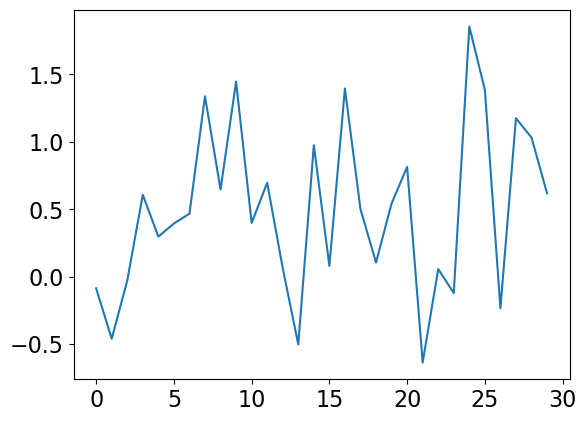

In [218]:
plt.plot(v_obs[:,0,0].real - vis_m[:N_time,0])
# plt.plot()

In [219]:
%timeit -r 3 U.lower(true_values, params, a1, a2, bl).compile()

198 ms ± 648 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [220]:
a1, a2 = jnp.triu_indices(N_ant, 1)
bl = jnp.arange(len(a1))
print()
print(f'Energy per data point @ true: {U(true_values, params, a1, a2, bl)/vis_obs.size}')
print()
print(f'U compiled {U._cache_size()} time(s).')


Energy per data point @ true: 2.122567761087899

U compiled 1 time(s).


In [221]:
# %timeit -r 7 U(true_values, params, a1, a2, bl).block_until_ready()

In [222]:
#jax.make_jaxpr(U)(true_values, params, a1, a2, bl)

In [223]:
# %timeit -r 1 jit(jacrev(model)).lower(true_values, params, a1[0], a2[0], bl[0]).compile()

In [225]:
###############################################################

F_prior = {'g_amp': {i: params['inv_cov_G_amp'] for i in range(N_ant)},
           'g_phase': {i: params['inv_cov_G_phase'] for i in range(N_ant-1)},
           'rfi_amp': {i: jnp.eye(N_rfi_time)/params['rfi_amp_std']**2 for i in range(N_ant)},
           # 'rfi_real': {i: jnp.eye(N_rfi_time)/params['rfi_amp_std']**2 for i in range(N_ant)},
           # 'rfi_imag': {i: jnp.eye(N_rfi_time)/params['rfi_amp_std']**2 for i in range(N_ant)},
           # 'rfi_orbit': params['inv_cov_RFI_orbit'],
           'v_real': params['inv_cov_vis'],
           'v_imag': params['inv_cov_vis'],
          }

# zeros_like = lambda x: jnp.zeros((x.size,x.size))
# F_prior = tree_map(zeros_like, true_values)

####################################

def fisher_diag_baseline(q, params, a1, a2, bl):
    
    Jac_model = jacrev(model)(q, params, a1, a2, bl)
    F_block = tree_map(lambda J: (J**2).sum(axis=0)/params['noise']**2, Jac_model)

    return F_block

def fisher_diag(q, params, ant1, ant2, baseline, F_prior):
    
    @progress_bar_scan(N_bl)
    def add_baseline_fisher(F, i):
        F_i = fisher_diag_baseline(q, params, ant1[i], ant2[i], baseline[i])
        return tree_map(lambda x, y: x+y, F, F_i), i
    
    return scan(add_baseline_fisher, F_prior, jnp.arange(N_bl))[0]

def fisher_diag(q, params, ant1, ant2, baseline, F_prior):
    
    Jacmodel = jit(jacrev(model))
    
    def fisher_diag_baseline(q, params, a1, a2, bl):
    
        J, _ = flatten((q, params, a1, a2, bl))
        F_diag = ((J/params['noise'])**2).sum(axis=0)

        return F_diag
    
#     @progress_bar_scan(N_bl)
    def add_baseline_fisher(F, i):
        F_i = fisher_diag_baseline(q, params, ant1[i], ant2[i], baseline[i])
        return F + F_i
    
    
    F, unflatten = flatten(F_prior)
    for i in tqdm(range(N_bl)):
        F = add_baseline_fisher(F, i)
    
    return unflatten(F)



def fisher_block(q, params, ant1, ant2, baseline, F_prior):
    
    Jac_model = jacrev(model)
    
    def fisher_block_baseline(q, params, a1, a2, bl):
        
        J = Jac_model(q, params, a1, a2, bl)
        F_block = tree_map(lambda J: J.T@J/params['noise']**2, J)

        return F_block

    @progress_bar_scan(N_bl)
    def add_baseline_fisher(F, i):
        F_i = fisher_block_baseline(q, params, ant1[i], ant2[i], baseline[i])
        return tree_map(lambda x, y: x+y, F, F_i), i
    
    return scan(add_baseline_fisher, F_prior, jnp.arange(N_bl))[0]

################
def block_std(F_block):

    std = tree_map(lambda F: jnp.sqrt(jnp.diag(jnp.linalg.inv(F))), F_block)

    return std

#############################################################

q_dev = {'v_real': {i: x for i, x in enumerate(0.65*random.normal(random.PRNGKey(10), (N_bl,)))},
         'v_imag': {i: x for i, x in enumerate(0.65*random.normal(random.PRNGKey(11), (N_bl,)))},
         'g_amp':  {i: x for i, x in enumerate(1.0*random.normal(random.PRNGKey(12), (N_ant,)))},
         'g_phase': {i: x for i, x in enumerate(1.0*random.normal(random.PRNGKey(13), (N_ant-1,)))},
         # 'rfi_amp': {i: x for i, x in enumerate(0.1*random.normal(random.PRNGKey(14), (N_ant,)))},
         'rfi_real': {i: x for i, x in enumerate(0.1*random.normal(random.PRNGKey(14), (N_ant,)))},
         'rfi_imag': {i: x for i, x in enumerate(0.1*random.normal(random.PRNGKey(14), (N_ant,)))},
         'rfi_orbit': random.multivariate_normal(random.PRNGKey(15),
                                                 jnp.zeros(len(cov_RFI_orbit)),
                                                 1e0*cov_RFI_orbit)
        }

q_dev = {'v_real': {i: 1*0.65*random.normal(random.PRNGKey(10+i), (n_vis_times[i],)) for i in range(N_bl)},
         'v_imag': {i: 1*0.65*random.normal(random.PRNGKey(100+i), (n_vis_times[i],)) for i in range(N_bl)},
         'g_amp':  {i: x for i, x in enumerate(1.0*random.normal(random.PRNGKey(12), (N_ant,)))},
         'g_phase': {i: x for i, x in enumerate(1.0*random.normal(random.PRNGKey(13), (N_ant-1,)))},
         'rfi_amp': {i: x for i, x in enumerate(0.1*random.normal(random.PRNGKey(14), (N_ant,)))},
         # 'rfi_real': {i: x for i, x in enumerate(5*0.1*random.normal(random.PRNGKey(14), (N_ant,)))},
         # 'rfi_imag': {i: x for i, x in enumerate(5*0.1*random.normal(random.PRNGKey(14), (N_ant,)))},
         # 'rfi_orbit': random.multivariate_normal(random.PRNGKey(15),
         #                                         jnp.zeros(len(cov_RFI_orbit)),
         #                                         1e0*cov_RFI_orbit)
        }

qi = tree_map(lambda x, y: x + y, true_values, q_dev)

# qi = {
#     'v_real': 

#########################################

print()
print(f'Number of data points: {2*params["vis_obs"].size}')
print()
print(f'Number of parameters: {len(flatten(qi)[0])}')
print()
print(f'Energy per data point @ qi: {U(qi, params, a1, a2, bl)/params["vis_obs"].size}')
print()
# print(f'U compiled {U._cache_size()} time(s).')
# print()


Number of data points: 360

Number of parameters: 158

Energy per data point @ qi: 792.0477690031184



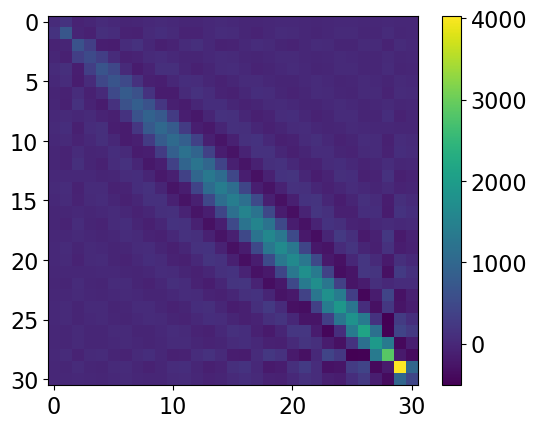

In [254]:
plt.imshow(F['rfi_amp'][0])
plt.colorbar()

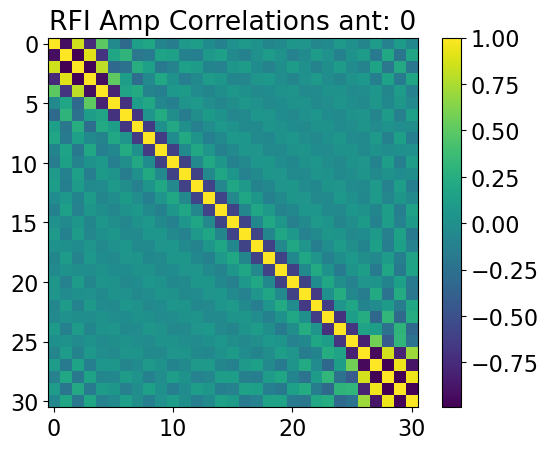

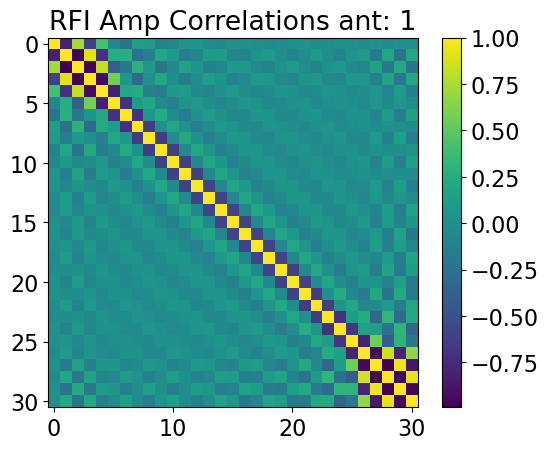

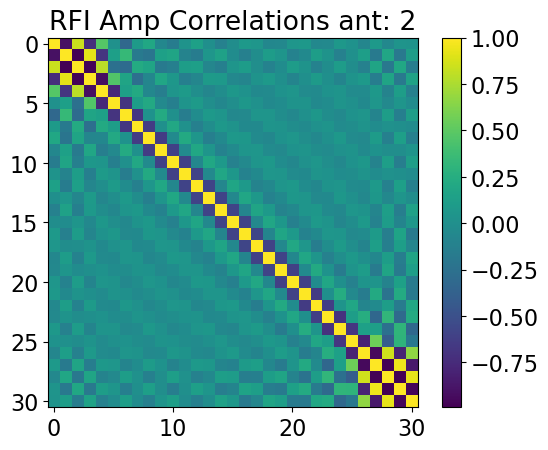

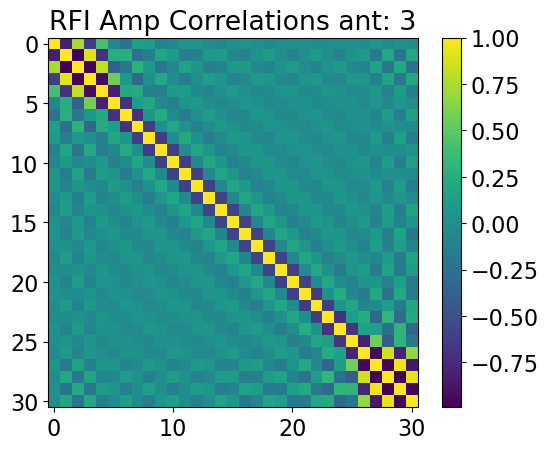

In [260]:
for i in range(N_ant):
    plt.figure()
    plt.title(f'RFI Amp Correlations ant: {i}')
    std = jnp.sqrt(jnp.diag(F_inv['rfi_amp'][i]))
    plt.imshow(F_inv['rfi_amp'][i]/std[:,None]/std[None,:])
    plt.colorbar()

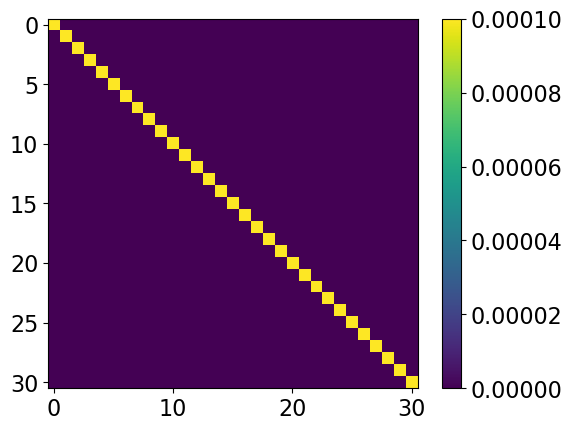

In [255]:
plt.imshow(F_prior['rfi_amp'][0])
plt.colorbar()

In [226]:
# %timeit -r 7 U(qi, params, a1, a2, bl).block_until_ready()

In [272]:
F = fisher_block(true_values, params, a1, a2, bl, F_prior)
F_inv = tree_map(jnp.linalg.inv, F)

Running for 6 iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 7393.02it/s]


In [227]:
# F = fisher_block(qi, params, a1, a2, bl, F_prior)
# F_inv = tree_map(jnp.linalg.inv, F)

Running for 6 iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 7733.81it/s]


In [90]:
# F = fisher_block(qi, params, a1, a2, bl, F_prior)
# F_inv = tree_map(lambda x: 1./np.diag(x), F)

Running for 28 iterations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [03:31<00:00,  7.55s/it]


In [261]:
F_prior_diag = tree_map(jnp.diag, F_prior)
F = fisher_diag(qi, params, a1, a2, bl, F_prior_diag)
F_inv = tree_map(lambda x: 1./x, F)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.49it/s]


In [274]:
####################################################

@jit
def nat_grad_step(q, a1s, a2s, bls, alpha):
    
    update = lambda F_inv, D: alpha*F_inv@D
    # update = lambda F_inv, D: alpha*F_inv*D
    D = delU(q, params, a1s, a2s, bls)
    return tree_map(update, F_inv, D)
    

def nat_grad(qi, alpha, Niter=1000, tol=1e-6):
    a1, a2 = jnp.triu_indices(N_ant, 1)
    bl = jnp.arange(len(a1))
    U_i = U(qi, params, a1, a2, bl)/vis_obs.size
    pbar = tqdm(range(0, Niter))
    for i in pbar:
        # step = alpha*0.99**(i/100)
        step = alpha
        qf = tree_map(lambda x, y: x-y, qi, nat_grad_step(qi, a1, a2, bl, step))
        U_f = U(qf, params, a1, a2, bl)/vis_obs.size
        if i%100==1:
            pbar.set_description(f'NL Posterior = {round(float(U_f), 3)}, alpha = {step:.1E}')
        if np.isnan(U_f) or U_f > U_i :
            # print('Alpha halved')
            alpha /= 2
        elif jnp.abs(U_i-U_f) < tol:
            print('Tolerence reached')
            if U_f > U_i and U_f > 2.:
                print('Failed to converge!')
                return None
            return qi
        else:
            U_i = U_f
            qi = qf
    return qi

# MAP = nat_grad(qi, 1e-1, 10000, 1e-6)
# MAP = nat_grad(MAP, 2e-2, 10000, 1e-5)
MAP = nat_grad(true_values, 5e-2, 100000, 1e-9)
# MAP = true_values

# print()
# print(f'U compiled {U._cache_size()} time(s).')
# print()
# print(f'nat_grad_step compiled {nat_grad_step._cache_size()} time(s).')

NL Posterior = 1.545, alpha = 3.8E-07:  64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 64228/100000 [00:16<00:09, 3921.42it/s]


KeyboardInterrupt: 

In [43]:
def saveParams(file_path, q, F_inv):
    with h5py.File(file_path, 'w') as fp:
        fp['times_fine'] = times
        
        for i in range(len(q['v_real'])):
            fp[f'vis/{i}'] = q['v_real'][i] + 1.j*q['v_imag'][i]
            fp[f'vis_cov/{i}'] = F_inv['v_real'][i]
            fp[f'vis_times/{i}'] = vis_times[i]
        fp['vis_var'] = vis_var
        fp['vis_l'] = vis_l
        
        V_real = flatten(tree_map(pad_vis, q['v_real']))[0].reshape(N_bl, N_vis_time)
        V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)
        fp['vis_fine'] = vmap(jnp.dot)(params['resample_vis'], (V_real + 1.j*V_imag))
        
        G_amp = flatten(q['g_amp'])[0].reshape(N_ant, N_g_time)
        G_phase = flatten(q['g_phase'])[0].reshape(N_ant-1, N_g_time)
        G_phase = jnp.concatenate([G_phase, jnp.zeros((1, N_g_time))], axis=0)
        G = G_amp*jnp.exp(1.j*G_phase)
        fp['gains'] = G

        G_amp = (params['resample_g_amp']@G_amp.T)
        G_phase = (params['resample_g_phase']@G_phase.T)
        G = G_amp*jnp.exp(1.j*G_phase)
        fp['gains_fine'] = G
        
        # rfi_amp = flatten(q['rfi_amp'])[0].reshape(N_ant, N_rfi_time).T
        # fp['rfi_amp'] = rfi_amp
        # fp['rfi_amp_fine'] = params['resample_rfi']@rfi_amp
        fp['rfi_orbit'] = q['rfi_orbit']
        
        fp['g_amp_cov'] = flatten(F_inv['g_amp'])[0].reshape(N_ant,N_g_time,N_g_time)
        
        fp['g_phase_cov'] = flatten(F_inv['g_phase'])[0].reshape(N_ant-1,N_g_time,N_g_time)
        
        # fp['rfi_amp_cov'] = flatten(F_inv['rfi_amp'])[0].reshape(N_ant,N_rfi_time,N_rfi_time)
        fp['rfi_orbit_cov'] = F_inv['rfi_orbit']

In [44]:
save_path = f'data/Params_{N_ant}A_Complex.h5'

saveParams(save_path, MAP, F_inv)

In [45]:
print()
print('Estimating Posterior Errors')
print('---------------------------')

std = block_std(F)

with h5py.File(save_path, 'r') as fp:
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
    vis_times = {i: fp['vis_times'][f'{i}'][()] for i in range(N_bl)}
    vis_var_d = {i: fp['vis_var'][i] for i in range(N_bl)}
    vis_l_d = {i: fp['vis_l'][i] for i in range(N_bl)}
v_pred = jnp.concatenate([v_pred.real.flatten(), v_pred.imag.flatten()])
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time))
v_std = jnp.sqrt(jnp.concatenate([v_std.flatten(), v_std.flatten()]))
v_true = vis_ast.reshape(N_time, N_int_samples, -1).mean(axis=1)
v_true = jnp.concatenate([v_true.real.flatten(), v_true.imag.flatten()])
res = v_pred - v_true

bias = res/v_std

print()
print(f'RMSE : {jnp.sqrt(jnp.mean(res**2))}')
print()
print(f'STD : {v_std.mean()}')
print()
print('Normalized')
print('-----------')
print(f'Mean : {bias.mean()}')
print(f'STD : {bias.std()}')


Estimating Posterior Errors
---------------------------

RMSE : 0.07166845820204534

STD : 0.28661675203691456

Normalized
-----------
Mean : 0.011365177791222045
STD : 0.25322005637425565


In [46]:
b = jnp.abs(bias)
100*len(b[b<1])/len(b)

99.90079365079364

In [47]:
print()
print(f'End Time : {datetime.now()}')
print()
print(f'Time Taken: {datetime.now()-start}')


End Time : 2023-05-29 12:32:11.109989

Time Taken: 0:19:06.389431


Text(0, 0.5, 'Visibility Real [Jy]')

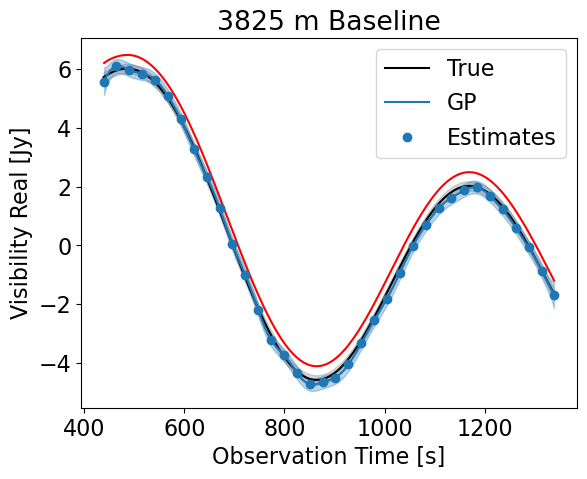

In [54]:
bl = int(jnp.argmin(flatten(vis_l)[0]))
n_std = 2

with h5py.File(save_path, 'r') as fp:
    vis = {i: fp[f'vis'][f'{i}'][()] for i in range(N_bl)}
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time)).T

est = vis[bl].real
mean = v_pred[:,bl].real
std = v_std[:,bl]
true = vis_ast[:,bl,0].real
noise = noise/jnp.sqrt(2.)

plt.plot(times, params['resample_vis'][bl]@qi['v_real'][bl], 'r')

plt.plot(times_fine, true, color='k', label='True')
plt.fill_between(times_fine, true-n_std*noise, true+n_std*noise, 
                 color='tab:grey', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(times, mean, color='tab:blue', label='GP')
plt.fill_between(times, mean-n_std*std, mean+n_std*std, 
                 color='tab:blue', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(vis_times[bl], est, 'o', color='tab:blue', label='Estimates')

plt.legend()
plt.title(f'{round(mag_uvw[bl])} m Baseline')
plt.xlabel('Observation Time [s]')
plt.ylabel('Visibility Real [Jy]')

Text(0, 0.5, 'Visibility Real [Jy]')

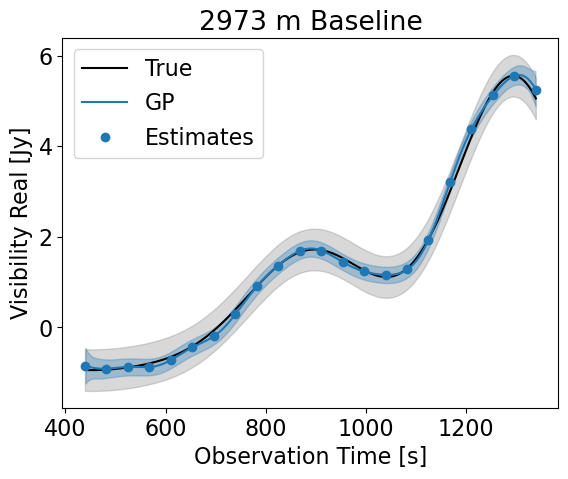

In [49]:
bl = int(jnp.argmin((mag_uvw-3000)**2))
n_std = 2

with h5py.File(save_path, 'r') as fp:
    vis = {i: fp[f'vis'][f'{i}'][()] for i in range(N_bl)}
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time)).T

est = vis[bl].real
mean = v_pred[:,bl].real
std = v_std[:,bl]
true = vis_ast[:,bl,0].real
noise = noise/jnp.sqrt(2.)

plt.plot(times_fine, true, color='k', label='True')
plt.fill_between(times_fine, true-n_std*noise, true+n_std*noise, 
                 color='tab:grey', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(times, mean, color='tab:blue', label='GP')
plt.fill_between(times, mean-n_std*std, mean+n_std*std, 
                 color='tab:blue', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(vis_times[bl], est, 'o', color='tab:blue', label='Estimates')

plt.legend()
plt.title(f'{round(mag_uvw[bl])} m Baseline')
plt.xlabel('Observation Time [s]')
plt.ylabel('Visibility Real [Jy]')

Text(0, 0.5, 'Visibility Real [Jy]')

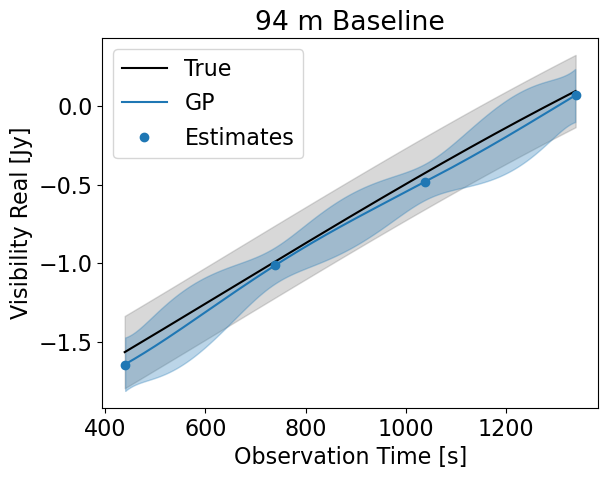

In [49]:
bl = int(jnp.argmax(flatten(vis_l)[0]))
n_std = 2

with h5py.File(save_path, 'r') as fp:
    vis = {i: fp[f'vis'][f'{i}'][()] for i in range(N_bl)}
    v_pred = fp['vis_fine'][()].T
    noise_cov = {i: fp['vis_cov'][f'{i}'][()] for i in range(N_bl)}
cov_fine = tree_map(resampled_cov, vis_times, {i: times for i in range(N_bl)}, vis_var_d, vis_l_d, noise_cov)
v_std = vmap(lambda x: jnp.sqrt(jnp.diag(x)))(flatten(cov_fine)[0].reshape(N_bl,N_time,N_time)).T

est = vis[bl].real
mean = v_pred[:,bl].real
std = v_std[:,bl]
true = vis_ast[:,bl,0].real
noise = noise/jnp.sqrt(2.)

plt.plot(times_fine, true, color='k', label='True')
plt.fill_between(times_fine, true-n_std*noise, true+n_std*noise, 
                 color='tab:grey', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(times, mean, color='tab:blue', label='GP')
plt.fill_between(times, mean-n_std*std, mean+n_std*std, 
                 color='tab:blue', alpha=0.3, 
#                  label=f'{int(n_std)}'+r'$\sigma$'
                )
plt.plot(vis_times[bl], est, 'o', color='tab:blue', label='Estimates')

plt.legend()
plt.title(f'{round(mag_uvw[bl])} m Baseline')
plt.xlabel('Observation Time [s]')
plt.ylabel('Visibility Real [Jy]')

In [18]:
@jit
def vis_prior(q):
    V_real = flatten(tree_map(pad_vis, q['v_real']))[0].reshape(N_bl, N_vis_time)
#     V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)
    return log_multinorm_sum(V_real, jnp.zeros(N_bl), inv_cov_vis)

In [19]:
@jit
def vis_prior2(q):
    V_real = flatten(q['v_real'])[0]
#     V_imag = flatten(tree_map(pad_vis, q['v_imag']))[0].reshape(N_bl, N_vis_time)
    return log_normal(V_real, jnp.zeros(len(V_real)), sigma).sum()

In [20]:
%timeit -r 7 vis_prior.lower(true_values).compile()

7.41 s ± 342 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit -r 7 vis_prior2.lower(true_values).compile()

417 ms ± 943 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
vis_prior(true_values)

Array(-139.85498607, dtype=float64)

In [23]:
vis_prior2(true_values)

Array(-178.49932835, dtype=float64)

In [24]:
log_multinorm_sum_dict(true_values['v_real'], params['mu_vis'], params['inv_cov_vis'])

NameError: name 'log_multinorm_sum_dict' is not defined

In [13]:
@jit
def log_multinorm_dict(x, mu, inv_cov):
    return tree_multimap(log_multinorm, x, mu, inv_cov)

In [14]:
%timeit -r 7 log_multinorm_dict.lower(true_values['v_real'], params['mu_vis'], params['inv_cov_vis']).compile()

9.46 s ± 597 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit -r 7 log_multinorm_sum_dict.lower(true_values['v_real'], params['mu_vis'], params['inv_cov_vis']).compile()

NameError: name 'log_multinorm_sum_dict' is not defined

In [ ]:
%timeit -r 7 log_multinorm_sum_array.lower(flatten(true_values['g_amp'])[0].reshape(N_ant, N_g_time), params['mu_G_amp'], params['inv_cov_G_amp']).compile()

In [4]:
# class tabascal:
#     def __init__(self, n_ant: int, times: jnp.ndarray, times_fine: jnp.ndarray, freqs: jnp.ndarray, 
#                  qi: dict, true_values: dict, n_int_samples: int, n_rfi_time: int, n_g_time: int, 
#                  n_vis_time: int, scalings: dict, inv_scalings: dict, n_bl: int, noise: float, 
#                  vis_obs: jnp.ndarray, ants_xyz: jnp.ndarray, phase_corrections: jnp.ndarray, 
#                  resamplings: dict, antenna1: jnp.ndarray, antenna2: jnp.ndarray
#                 ):
        
#         self.n_ant = n_ant
#         self.n_time = len(times)
#         self.n_int_samples = n_int_samples
#         self.n_rfi_time = n_rfi_time
#         self.n_g_time = n_g_time
#         self.n_vis_time = n_vis_time
#         self.qi = qi
#         self.q = qi
#         self.times = times
#         self.freqs = freqs
#         self.scalings = scalings
#         self.inv_scalings = inv_scalings
#         self.n_bl = n_bl
#         self.times = times
#         self.times_fine = times_fine
#         self.noise = noise
#         self.ants_xyz = ants_xyz
#         self.phase_corrections = phase_corrections
#         self.vis_obs = vis_obs
#         self.resamplings = resamplings
#         self.true_values = true_values#self.scale_parameters(true_values, scalings)
#         self.antenna1 = antenna1
#         self.antenna2 = antenna2
#         self.baselines = jnp.arange(n_bl)
    
#     @jit
#     def rfi_closures(self, q, ants):

#         rfi_amp = flatten(q['rfi_amp'])[0].reshape(self.n_ant,
#                                                         self.n_rfi_time)[ants]
#         rfi_amp = (self.resamplings['resample_rfi']@rfi_amp.T).T

#         rfi_xyz = orbit(self.times_fine, *q['rfi_orbit'])
#         distances = jnp.linalg.norm(self.ants_xyz[:,ants]-rfi_xyz[:,None,:], axis=2)
#         c_distances = (distances-self.phase_corrections[:,ants])[...,None]

#         return rfi_amp, c_distances
        
#     @jit
#     def rfi_vis(self, app_amplitude, c_distances, freqs):
#         '''
#         Calculate visibilities from distances to rfi sources.

#         Parameters:
#         -----------
#         app_amplitude: jnp.array (n_time, 2, n_freq, n_src)
#             Apparent amplitude at the antennas.
#         c_distances: jnp.array (n_time, 2, n_src)
#             The phase corrected distances between the rfi sources and the antennas.
#         freqs: jnp.array (n_freq,)
#             Frequencies.

#         Returns:
#         --------
#         vis: jnp.array (n_time, 1, n_freq)
#             The visibilities.
#         '''
#         n_time, n_ant, n_freq, n_src = app_amplitude.shape
#         c = 2.99792458e8

#         # Create array of shape (n_time, n_bl, n_freq, n_src) and then sum over n_src

#         minus_two_pi_over_lamda = (-2.0*jnp.pi*freqs/c).reshape(1,1,n_freq,1)

#         c_distances = c_distances.reshape(n_time,n_ant,1,n_src)

#         phase = minus_two_pi_over_lamda*(c_distances[:,0]-c_distances[:,1])
#         intensities_app = app_amplitude[:,0]*app_amplitude[:,1]

#         vis = jnp.sum(intensities_app*jnp.exp(-1.j*phase), axis=-1)

#         return vis

#     @jit
#     def baseline_gains(self, q, ants):

#         G_amp = flatten(q['g_amp'])[0].reshape(self.n_ant, self.n_g_time)[ants]
#         G_phase = flatten(q['g_phase'])[0].reshape(self.n_ant-1, self.n_g_time)
#         G_phase = jnp.concatenate([G_phase, jnp.zeros((1, N_g_time))], axis=0)[ants]

#         G_amp = (self.resamplings['resample_g_amp']@G_amp.T).T
#         G_phase = (self.resamplings['resample_g_phase']@G_phase.T).T

#         G = G_amp*jnp.exp(1.j*G_phase)

#         return G[0]*jnp.conjugate(G[1])

#     @jit
#     def model(self, ant1, ant2, bl):

#         q = self.scale_parameters(self.q, self.inv_scalings)

#         ants = jnp.array([ant1, ant2])

#         V_real = flatten(q['v_real'])[0].reshape(self.n_bl, self.n_vis_time)[bl]
#         V_imag = flatten(q['v_imag'])[0].reshape(self.n_bl, self.n_vis_time)[bl]
#         V_ast = V_real + 1.j*V_imag

#         V_ast = self.resamplings['resample_vis'][bl]@V_ast

#     #     Calculate the visibility contribution from the RFI
#         rfi_amp, c_distances = self.rfi_closures(q, ants)
#         V_rfi = self.rfi_vis(rfi_amp.T[:,:,None,None], c_distances, self.freqs)[...,0]
#         V_rfi = V_rfi.reshape(self.n_time, self.n_int_samples).mean(axis=1)

#         G_bl = self.baseline_gains(q, ants)

#         model_vis = (G_bl*(V_ast+V_rfi))

#         return jnp.concatenate([model_vis.real.flatten(), model_vis.imag.flatten()])

#     @jit
#     def scale_parameters(self, q, scalings):
#         q['g_amp'] = tree_map(lambda x: scalings['g_amp']*x, q['g_amp'])
#         q['g_phase'] = tree_map(lambda x: scalings['g_phase']*x, q['g_phase'])
#         q['rfi_orbit'] = scalings['rfi_orbit']@q['rfi_orbit']
#         return q

    
#     @jit
#     def nll(self, ant1, ant2, bl):

#         V_model = self.model(ant1, ant2, bl)

#         V_obs = jnp.concatenate([self.vis_obs[:,bl].real,
#                                  self.vis_obs[:,bl].imag])

#         return -1. * log_normal(V_obs, V_model, self.noise/jnp.sqrt(2))
    
    
#     @jit
#     def U(self):

#         nl_like = vmap(self.nll, in_axes=(0,0,0))(self.antenna1, self.antenna2, self.baselines).sum()
#         return nl_like
# #         nl_post = nlp(q, params) + nl_like

# #         return nl_post
    
#     def _tree_flatten(self):
#         children = (
# #                     self.qi, 
# #                     self.q,
#                    )  # arrays / dynamic values
#         aux_data = {'qi': self.qi,
#                     'true_values': self.true_values,
#                     'times': self.times,
#                     'times_fine': self.times_fine,
#                     'freqs': self.freqs,
#                     'n_ant': self.n_ant,
#                     'n_int_samples': self.n_int_samples,
#                     'n_rfi_time': self.n_rfi_time,
#                     'n_g_time': self.n_g_time,
#                     'n_vis_time': self.n_vis_time,
#                     'n_bl': self.n_bl,
#                     'scalings': self.scalings,
#                     'inv_scalings': self.scalings,
#                     'noise': self.noise,
#                     'vis_obs': self.vis_obs,
#                     'ants_xyz': self.ants_xyz,
#                     'phase_corrections': self.phase_corrections,
#                     'resamplings': self.resamplings,
#                     'antenna1': self.antenna1,
#                     'antenna2': self.antenna2,
# #                     'baselines': self.baselines
# #                     'n_time': self.n_time,
# #                     'n_rfi_time': self.n_rfi_time,
# #                     'true_values': self.true_values,
#                    }  # static values
#         return (children, aux_data)

#     @classmethod
#     def _tree_unflatten(cls, aux_data, children):
#         return cls(*children, **aux_data)

# from jax import tree_util
# tree_util.register_pytree_node(tabascal,
#                                tabascal._tree_flatten,
#                                tabascal._tree_unflatten)

In [5]:
# scalings = {'g_amp': jnp.array([100.]),
#             'g_phase': jnp.rad2deg(1.),
#             'rfi_orbit': jnp.diag(jnp.array([1e-2, 3600e0, 3600e1, 3600e1]))}

# inv_scalings = tree_map(lambda x: jnp.linalg.inv(x) if x.ndim==2 else 1./x, scalings)

# Nt_fine = len(tar.times_fine)
# #####
# Nt_g = N_int_samples*45
# g_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_g)) + \
#                 [Nt_fine-1,])
# times_g = tar.times_fine[g_idx]
# N_g_time = len(times_g)
# G = tar.gains_ants[g_idx,:,0].T
# #####
# Nt_rfi = 2**5
# rfi_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_rfi)) + \
#                 [Nt_fine-1,])
# times_rfi = tar.times_fine[rfi_idx]
# N_rfi_time = len(times_rfi)
# rfi_A = tar.rfi_A_app[rfi_idx,:,0].T
# ######
# Nt_vis = 150
# vis_idx = jnp.array(list(np.arange(0, Nt_fine, Nt_vis)) + \
#                 [Nt_fine-1,])
# times_vis = tar.times_fine[vis_idx]
# N_vis_time = len(times_vis)
# vis_ast = tar.vis_ast[vis_idx,:,0].T
# ######
# true_values = {'g_amp': {i: x for i, x in enumerate(jnp.abs(G))},
#                'g_phase': {i: x for i, x in enumerate(jnp.angle(G[:-1]))},
#                'rfi_amp': {i: x for i, x in enumerate(rfi_A)},
#                'rfi_orbit': tar.rfi_orbit,
#                'v_real': {i: x for i, x in enumerate(vis_ast.real)},
#                'v_imag': {i: x for i, x in enumerate(vis_ast.imag)}
#                }

# def l_from_uv(uv, l0=7e2, a=6e-4):
#     return l0*jnp.exp(-a*uv)

# a1, a2 = jnp.triu_indices(N_ant, 1)
# mag_uvw = jnp.linalg.norm(tar.ants_uvw[0, a1] - tar.ants_uvw[0, a2], axis=-1)
# vis_var = (jnp.abs(tar.vis_ast).max(axis=(0,2)) + noise)**2
# vis_l = l_from_uv(mag_uvw, l0=5e2)

# g_amp_var = (0.01*scalings['g_amp'])**2
# g_phase_var = (jnp.deg2rad(1.)*scalings['g_phase'])**2
# g_l = 5e2

# rfi_var, rfi_l = 1e6, 15.

# resamplings = {'resample_vis': vmap(resampling_kernel, 
#                                     in_axes=(None,None,0,0,None))(times_vis, 
#                                                                   tar.times, 
#                                                                   vis_var, vis_l, 1e-3),
#                 'resample_g_amp': resampling_kernel(times_g, 
#                                                     tar.times, 
#                                                     g_amp_var, g_l, 1e-8),
#                 'resample_g_phase': resampling_kernel(times_g, 
#                                                       tar.times, 
#                                                       g_phase_var, g_l, 1e-8),
#                 'resample_rfi': resampling_kernel(times_rfi, 
#                                                   tar.times_fine, 
#                                                   rfi_var, rfi_l, 1e-6)
#               }

In [6]:
# tab = tabascal(n_ant=tar.n_ants, times=tar.times, times_fine=tar.times_fine, freqs=tar.freqs, 
#                qi=true_values, n_int_samples=tar.n_int_samples, n_rfi_time=N_rfi_time, 
#                n_g_time=N_g_time, n_vis_time=N_vis_time, n_bl=tar.n_bl, noise=tar.noise,
#                scalings=scalings, inv_scalings=inv_scalings, vis_obs=tar.vis_obs, 
#                ants_xyz=tar.ants_xyz, phase_corrections=tar.ants_uvw[...,-1], 
#                resamplings=resamplings, true_values=true_values, 
#                antenna1=tar.a1, antenna2=tar.a2)

In [7]:
# tab.rfi_closures(true_values, np.arange(2))[0].shape

In [8]:
# plt.plot(tab.model(0, 1, 0))

In [9]:
# tab.U()